# Pydna Gel Electrophoresis Simulation

This is a short example of how the DNA gel electrophoresis simulation in pydna can be used.

### Inline plots

"`%matplotlib inline`" causes the plots to be draw inline in the notebook as static images.  
"`%matplotlib notebook`" shows the plots inline with limited interactive features like pan and zoom.

**Note:** The interactive features of the electrophoresis plots, like clickable bands, cannot be used inline.

In [1]:
# %matplotlib inline
%matplotlib notebook

### Imports

In [2]:
import pydna
from pydna.gel import weight_standards, weight_standard_sample, Q_
from Bio.Restriction import ZraI, BamHI, SmaI

### Convenience functions for printing

In [3]:
def printN(sample):
    print(Q_([seq.n for seq in sample], 'mol').to('pmol'))


def printM(sample):
    print(Q_([seq.m() for seq in sample], 'g').to('ng'))

### Get a DNA weight standard

A DNA ladder can be defined as a list of **`Dseqrecords`** like any other sample for electrophoresis.  
The parameters of a few commercial weight standards are available in **`weight_standard`** for convenience.  
A sample from these standards with a given total weight (500 ng by default) can be created with **`weight_standard_sample`**.

In [4]:
# Commercial DNA weight standards available
weight_standards.keys()

dict_keys(['Mix_GeneRuler', '1kb+_GeneRuler', '1kb_GeneRuler', 'High_Range_GeneRuler'])

In [5]:
# Example of the parameters of a weight standard
weight_standards['1kb+_GeneRuler']

{'percent': <Quantity([ 0.04  0.04  0.04  0.15  0.04  0.04  0.04  0.16  0.05  0.05  0.15  0.05
   0.05  0.05  0.05], 'dimensionless')>,
 'sizes': <Quantity([20000 10000  7000  5000  4000  3000  2000  1500  1000   700   500   400
    300   200    75], 'base_pair')>}

In [6]:
# DNA weight standard sample definition (500 ng)
st = weight_standard_sample('1kb+_GeneRuler')

printN(st)
printM(st)

[ 0.00161864  0.00323725  0.00462462  0.02427908  0.00809298  0.01079052  0.01618543  0.08632047  0.040461    0.05779826  0.24273494  0.1011331  0.13482976  0.20220157  0.53863059] pmol
[ 20.  20.  20.  75.  20.  20.  20.  80.  25.  25.  75.  25.  25.  25.  25.] ng


### Get _Kluyveromyces lactis_ LAC12 gene from GenBank

In [7]:
# Tell GenBank who you are
gb = pydna.Genbank("myself@email.com")

# Kluyveromyces lactis LAC12 gene for lactose permease
gene = gb.nucleotide("X06997")

### Define the primers

In [8]:
primer_f, primer_r = pydna.parse(
    ''' >760_KlLAC12_rv (20-mer)
                                     ttaaacagattctgcctctg

                                     >759_KlLAC12_fw (19-mer)
                                     aaatggcagatcattcgag
                                     ''',
    ds=False,
)

### PCR amplification

In [9]:
# PCR
pcr_prod = [pydna.pcr(primer_f, primer_r, gene)]

# PCR product
printN(pcr_prod)
printM(pcr_prod)
pcr_prod

[ 0.05] pmol
[ 54.55532] ng


[Dseqrecord(-1766)]

### Gel electrophoresis of PCR product

<IPython.core.display.Javascript object>


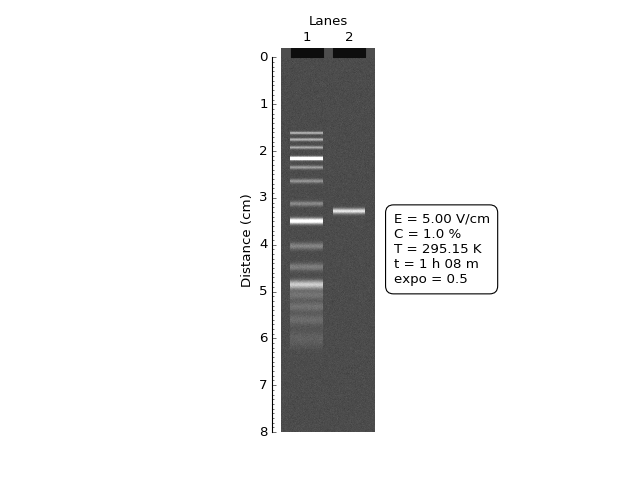

In [10]:
pydna.Gel([st, pcr_prod]).run()

### Get cloning vector pUC19 from GenBank

In [11]:
pUC19 = gb.nucleotide("M77789")

printN([pUC19])
printM([pUC19])

[ 0.05] pmol
[ 82.98877] ng


### Linearize vector with SmaI restriction enzyme
```
5' ... C C C ↓ G G G ... 3'
3' ... G G G ↑ C C C ... 5'
```

In [12]:
# restriction
frags = pUC19.cut(SmaI)

# restriction product (1 cut)
printN(frags)
printM(frags)
frags

[ 0.05] pmol
[ 82.98877] ng


[Dseqrecord(-2686)]

### Gel electrophoresis of restriction product

<IPython.core.display.Javascript object>


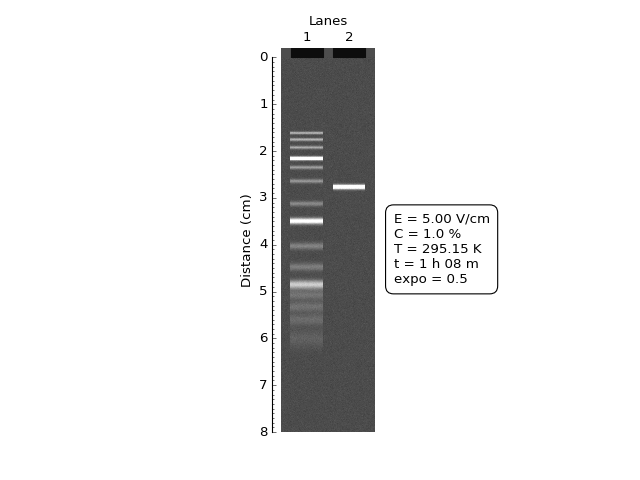

In [13]:
pydna.Gel([st, frags]).run()

### Loop the linearized vector and the gene in a recombinant vector

In [14]:
# The PCR and restriction products are lists because they may have multiple sequences
# We verified that in this case and as expected they only contain one sequence each
lin_vector = frags[0]
insert = pcr_prod[0]

# Recombinant vector looping
rec_vec = (lin_vector + insert).looped()

# Result
printN([rec_vec])
printM([rec_vec])
rec_vec

[ 0.05] pmol
[ 137.54014] ng


Dseqrecord(o4452)

### Gel electrophoresis of recombinant vector

<IPython.core.display.Javascript object>


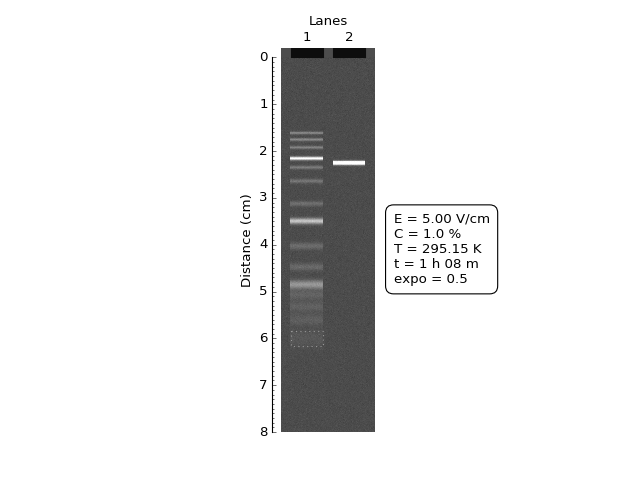

In [15]:
pydna.Gel([st, [rec_vec]]).run()

### Gel electrophoresis - Demonstration with multiple lanes

Note that the first parameter of `Gel` (`samples`) is a list of lists of `Dseqrecords`.  
Each inner list defines a different lane.

<IPython.core.display.Javascript object>


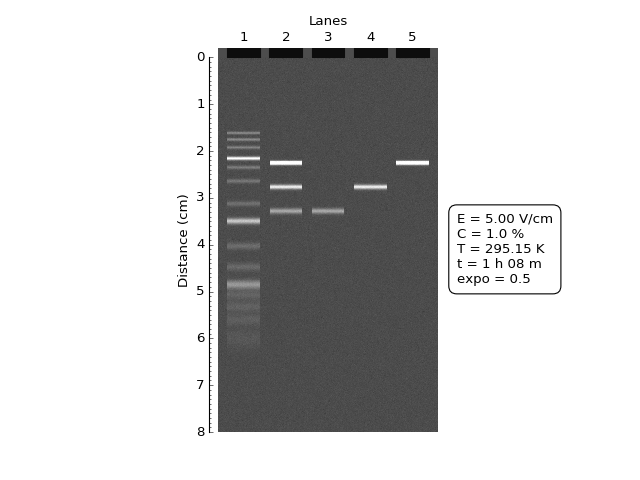

In [16]:
mix = [lin_vector, insert, rec_vec]

pydna.Gel([st, mix, pcr_prod, frags, [rec_vec]]).run()

### Gel electrophoresis - Demonstration with quantities in different scales

So far the DNA quantity of all bands was roughly within the same scale (20-140 ng).  
If the DNA quantities in the bands differs by orders of magnitude, the heavier bands will saturate and the lighter bands will not be visible.  
When this is the case, a dotted oultine will appear around the invisible bands.

In [17]:
# Lets make the insert too light to be detected
insert.n = 1e-15

printN([insert])
printM([insert])

[ 0.001] pmol
[ 1.0911064] ng


<IPython.core.display.Javascript object>


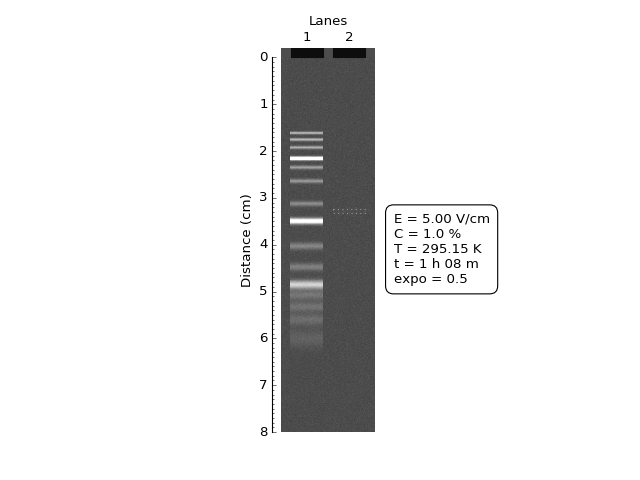

In [18]:
pydna.Gel([st, [insert]]).run()

### Gel electrophoresis - Demonstration of bands running off the gel

By default the gel runs the time necessary for the fastest band to reach 75% of the gel length (**`till_len=0.75`**), so that all bands are within the gel.  
A run time can be defined using the parameter **`till_time`** (hours).
If the gel runs for too long some bands may run off the gel.  
If both **`till_len`** and **`till_time`** are defined, the most restrictive one is used.

The previous gels ran for about an hour.  
With just 30 min we achieve much less separation.

<IPython.core.display.Javascript object>


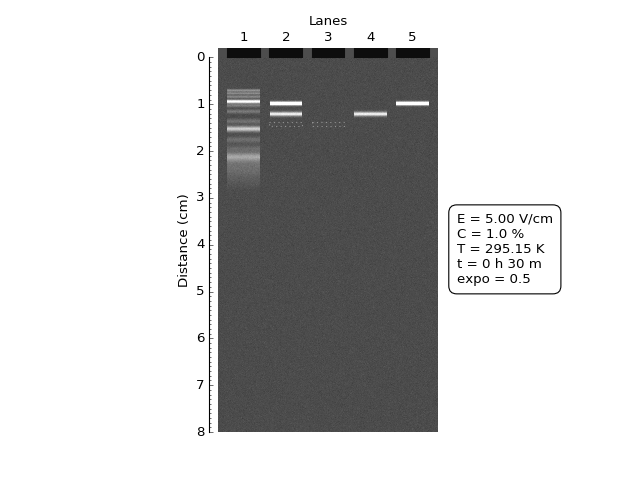

In [19]:
# 30 min
pydna.Gel([st, mix, pcr_prod, frags, [rec_vec]]).run(till_time=0.5)

If we set **`till_time`** to 2 hours it will still run for about one hour since it will stop at the most stringent stopping condition which is **`till_len=0.75`** (default).

<IPython.core.display.Javascript object>


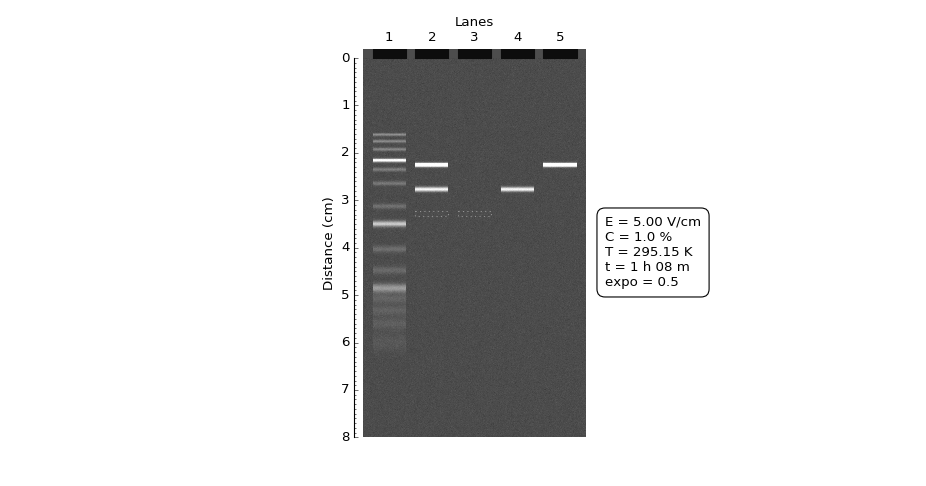

In [20]:
# 2 hours (will run for about one hour because `till_len=0.75` is more restrictive)
pydna.Gel([st, mix, pcr_prod, frags, [rec_vec]]).run(till_time=2)

Setting **`till_len`** to **`None`** the stopping condition will be the time.

<IPython.core.display.Javascript object>


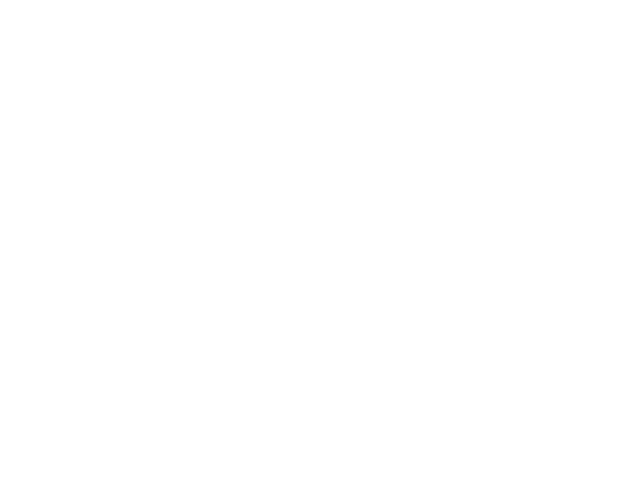

IndexError: index 1575 is out of bounds for axis 0 with size 1575

In [21]:
# 2 hours (`till_len=None`)
pydna.Gel([st, mix, pcr_prod, frags, [rec_vec]]).run(till_len=None, till_time=2)